In [1]:
import os
import urllib.request
import torch
import numpy as np
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
from anndata import AnnData
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
from scDGD.classes import GaussianMixture
from scDGD.models import DGD
from scDGD.functions import prepate_data, dgd_train
from scDGD.models import DGD
from scDGD.functions import prepate_data, dgd_train
from scDGD.classes.representation import RepresentationLayer

In [3]:
K562_ad = ad.read('K562.h5ad')

#筛选数量超过阈值的perturbation
thresh = 200
value_counts = K562_ad.obs['gene'].value_counts()

filtered_counts = value_counts[value_counts > thresh]
filtered_genes = filtered_counts.index

# 保留通过thresh的gene的行
filtered_data = K562_ad[K562_ad.obs['gene'].isin(filtered_genes)]

# 获取未通过thresh的gene的行
removed_data = K562_ad[~K562_ad.obs['gene'].isin(filtered_genes)]

#筛选出现在转录组里的perturbation

# 提取var表里的gene name列
gene_names_in_var = filtered_data.var['gene_name'].tolist()

# 提取obs表里的gene列
genes_in_obs = filtered_data.obs['gene'].value_counts().index.tolist()

genes_not_in_var = [gene for gene in genes_in_obs if gene not in gene_names_in_var]

genes_not_in_var.remove('non-targeting')

print("perturbation not in transcriptome:", len(genes_not_in_var))

#remove perturbation not in transcriptome
filtered_data = filtered_data[~filtered_data.obs['gene'].isin(genes_not_in_var)]


#filtered_data: perturbation with over 200 samples and in the transcriptome
filtered_data.obs['gene'].value_counts()

d:\anaconda\Lib\site-packages\anndata\__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


perturbation not in transcriptome: 29


gene
non-targeting    10691
RPL3              1996
NCBP2              992
KIF11              974
SLC39A9            752
                 ...  
HUS1               201
NELFCD             201
UBE2L3             201
UROD               201
TRMT112            201
Name: count, Length: 381, dtype: int64

In [4]:
filtered_data.var

,gene_name,chr,start,end,class,strand,length,in_matrix,mean,std,cv,fano
gene_id,,,,,,,,,,,,
ENSG00000237491,LINC01409,chr1,778747,810065,gene_version10,+,31318,True,0.137594,0.380048,2.762105,1.049733
ENSG00000228794,LINC01128,chr1,825138,868202,gene_version9,+,43064,True,0.256720,0.520162,2.026184,1.053944
ENSG00000188976,NOC2L,chr1,944203,959309,gene_version11,-,15106,True,1.975144,1.707837,0.864665,1.476706
ENSG00000187961,KLHL17,chr1,960584,965719,gene_version14,+,5135,True,0.119593,0.353702,2.957540,1.046089
ENSG00000188290,HES4,chr1,998962,1000172,gene_version10,-,1210,True,0.249577,0.561933,2.251540,1.265214
...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000278704,BX004987.1,GL000009.2,56140,58376,gene_version1,-,2236,True,0.241213,0.507266,2.102976,1.066768
ENSG00000274847,MAFIP,GL000194.1,53594,115055,gene_version1,-,61461,True,0.127525,0.361556,2.835168,1.025072
ENSG00000278384,AL354822.1,GL000218.1,51867,54893,gene_version1,-,3026,True,0.248814,0.516552,2.076062,1.072394


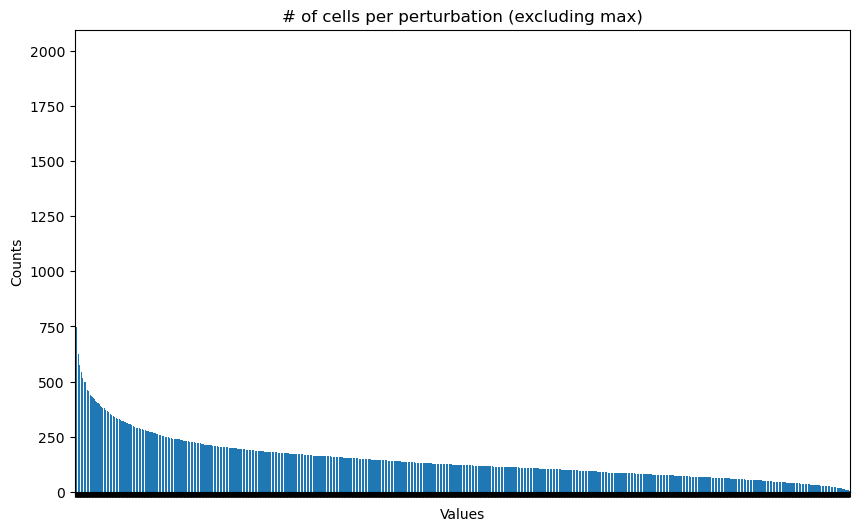

In [4]:
value_counts = K562_ad.obs['gene'].value_counts()
value_counts_excluding_max = value_counts.drop(value_counts.idxmax())

# 制作 count 数量的柱状图
ax = value_counts_excluding_max.plot(kind='bar', figsize=(10, 6), width=0.8)  # 增加柱子的宽度

# 取消 x 坐标标签展示
ax.set_xticklabels([])

# 添加标题和标签
plt.title('# of cells per perturbation (excluding max)')
plt.xlabel('Values')
plt.ylabel('Counts')

# 显示图表
plt.show()

In [5]:
#random sample 100 cell for each perturbation

np.random.seed(42)   # 设置随机种子，以便结果可重复
perturbations = filtered_data.obs['gene'].unique()

index = []

for perturbation in perturbations:
    # 选择当前 perturbation 的所有样本
    perturbation_data = filtered_data[filtered_data.obs['gene'] == perturbation]
    
    # 随机抽取 100 个样本
    sampled_indices = np.random.choice(perturbation_data.obs_names, size=thresh, replace=False)
    index.extend(sampled_indices)

# sampled_data: sampled from filtered_data, 200 samples for each perturbation
sampled_data = filtered_data[index]


In [6]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from scDGD.classes import scDataset

def prepate_data(adata, label_column, train_fraction=0.8, include_test=True, scaling_type='max', batch_size=256, num_w=0):
    '''
    Prepares the pytorch data sets and loaders for training and testing

    For integrating a new data set, set the train_fraction to 1. Otherwise there should always be something left for validation.
    If include_test is True, the split will also include a held-out test set. Otherwise, it will only be train and validation.
    '''

    ###
    # first create a data split
    ###
    labels = adata.obs[label_column]

    train_mode = True
    if 'train_val_test' not in adata.obs.keys():
        if train_fraction < 1.0:
            if include_test:
                train_indices, test_indices = train_test_split(np.arange(len(labels)), test_size=(1.0-train_fraction)/2, stratify=labels)
                train_indices, val_indices = train_test_split(train_indices, test_size=(((1.0-train_fraction)/2)/(1.0-(1.0-train_fraction)/2)), stratify=labels[train_indices])
                # add the split to the anndata object
                train_val_test = [''] * len(labels)
                train_val_test = ['train' if i in train_indices else train_val_test[i] for i in range(len(labels))]
                train_val_test = ['validation' if i in val_indices else train_val_test[i] for i in range(len(labels))]
                train_val_test = ['test' if i in test_indices else train_val_test[i] for i in range(len(labels))]
            else:
                train_indices, val_indices = train_test_split(np.arange(len(labels)), test_size=(1.0-train_fraction), stratify=labels)
                train_val_test = [''] * len(labels)
                train_val_test = ['train' if i in train_indices else train_val_test[i] for i in range(len(labels))]
                train_val_test = ['validation' if i in val_indices else train_val_test[i] for i in range(len(labels))]
        else:
            train_mode = False
            train_val_test = 'test'
        adata.obs['train_val_test'] = train_val_test
    else:
        if len(set(adata.obs['train_val_test'])) == 1:
            train_mode = False
    adata.obs['label'] = labels
    # make sure to afterwards also return the adata object so that the data split can be re-used

    if not include_test:
        adata_train = adata[adata.obs['train_val_test'] == 'train']
        adata_val = adata[adata.obs['train_val_test'] == 'validation']
    else:
        adata_train = adata[adata.obs['train_val_test'] == 'train']
        adata_val = adata[adata.obs['train_val_test'] == 'validation']
        adata_test = adata[adata.obs['train_val_test'] == 'test']

    ###
    # then create the data sets and loaders
    ###

    if train_mode:
        trainset = scDataset(
        adata_train.X,
        adata_train.obs,
        scaling_type=scaling_type,
        label_type='label'
        )
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_w)
        validationset = scDataset(
            adata_val.X,
            adata_val.obs,
            scaling_type=scaling_type,
            label_type='label'
        )
        validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=True, num_workers=num_w)
        if len(set(adata.obs['train_val_test'])) == 3:
            testset = scDataset(
                adata_test.X,
                adata_test.obs,
                scaling_type=scaling_type,
                label_type='label'
            )
            testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=num_w)
        else:
            testset, testloader = None, None
    else:
        testset = scDataset(
            adata.X,
            adata.obs,
            scaling_type=scaling_type,
            subset=np.where(adata.obs['train_val_test']=='test')[0],
            label_type='label'
        )
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=num_w)
    
    return adata_train,adata_val, trainloader, validationloader, testloader

from sklearn.decomposition import PCA

def plot_latent_pca_two(gmm, rep, labels, perturbation=None, n_components=2, cells_per_plot=20):

    if perturbation is not None:
        indices = np.where((labels == perturbation) | (labels == "non-targeting"))[0]
        gmm = gmm.cpu()
        embedding = rep.z[indices].detach().cpu().numpy().copy()
        labels = labels[indices]
    else:
        gmm = gmm.cpu()
        embedding = rep.z.detach().cpu().numpy()
        labels = labels

    # Apply PCA
    pca = PCA(n_components=n_components)
    projected = pca.fit_transform(embedding)
    plot_data = pd.DataFrame(projected, columns=[f"PCA{i+1}" for i in range(n_components)])
    plot_data["cell type"] = labels
    plot_data["cell type"] = plot_data["cell type"].astype("category")

    # Get unique cell types
    unique_cell_types = plot_data["cell type"].unique()
    
    # Calculate the number of subplots needed
    num_plots = int(np.ceil(len(unique_cell_types) / cells_per_plot))
    
    # Calculate the grid size for subplots
    cols = 4
    rows = int(np.ceil(num_plots / cols))
    
    # Make a plot
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows), constrained_layout=True)
    
    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for i in range(num_plots):
        # Get the range of cell types for this subplot
        start = i * cells_per_plot
        end = start + cells_per_plot
        current_cell_types = unique_cell_types[start:end]
        
        # Modify plot_data to replace other cell types with "others"
        plot_data["display_type"] = np.where(plot_data["cell type"].isin(current_cell_types),
                                             plot_data["cell type"], "others")
        
        # Separate the data for current cell types and others
        current_data = plot_data[plot_data["display_type"].isin(current_cell_types)]
        others_data = plot_data[plot_data["display_type"] == "others"]
        
        # Scatter plot for current cell types
        sns.scatterplot(data=current_data, x="PCA1", y="PCA2", hue="display_type", ax=axes[i], s=10)
        
        # Optionally scatter plot for others with transparent color
        sns.scatterplot(data=others_data, x="PCA1", y="PCA2", color="none", edgecolor="none", ax=axes[i], s=10)

        axes[i].set_title(f"Cell types {start + 1} to {min(end, len(unique_cell_types))}")
        axes[i].legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0, frameon=False, markerscale=4.0)

    # Turn off any unused subplots
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])
    '''
    plt.savefig("analysis_pca.pdf", bbox_inches="tight")
    plt.savefig("analysis_pca.png", bbox_inches="tight", dpi=500)
    '''
    plt.show()


In [7]:
###
# define desired hyperparameters
###
latent_dim = 50
n_epochs = 300

# define which feature should be observed in clustering (e.g. cell type or disease state)
adata_label_column_name = 'gene'

# prepare the data for training (and testing)
adata_train, adata_val, trainloader, validationloader, testloader = prepate_data(
    sampled_data,
    label_column=adata_label_column_name,
    train_fraction=0.9, 
    include_test=False,
)

latent_dim = 50
nsample = len(trainloader.dataset)

DGD = DGD(out=trainloader.dataset.n_genes, latent=latent_dim)
rep = RepresentationLayer(nrep=latent_dim, nsample=nsample,values=torch.zeros(size=(nsample,latent_dim)))
gmm = GaussianMixture(Nmix=1, dim=latent_dim)
DGD.load_state_dict(torch.load('./scDGD_thresh200_epo300/scDGD_thresh200_epo300_decoder.pt'))
rep.load_state_dict(torch.load('./scDGD_thresh200_epo300/scDGD_thresh200_epo300_representation.pt'))
gmm.load_state_dict(torch.load('./scDGD_thresh200_epo300/scDGD_thresh200_epo300_gmm.pt'))

labels = adata_train.obs["gene"].values

C:\Users\xrdpa\AppData\Local\Temp\ipykernel_14384\3367955863.py:38: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['train_val_test'] = train_val_test


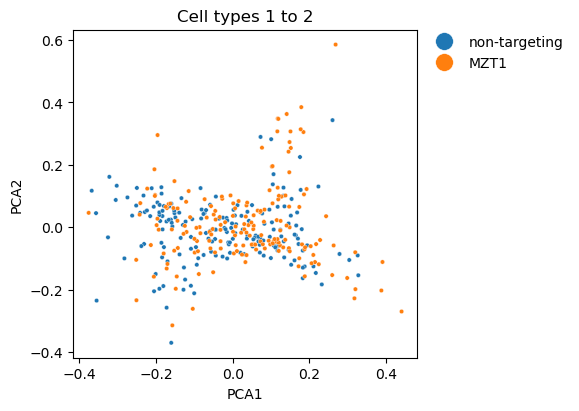

In [8]:
gene_name = "MZT1"
plot_latent_pca_two(gmm, rep, labels, perturbation=gene_name)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_latent_pca_multi(gmm, rep, labels, target_labels=None, n_components=2):
    # 确保GMM模型在CPU上
    gmm = gmm.cpu()
    labels = np.array(labels)
    
    # 筛选目标标签的数据
    if target_labels is not None:
        if not isinstance(target_labels, (list, np.ndarray)):
            raise ValueError("target_labels should be a list or a NumPy array")
        
        if isinstance(target_labels, list):
            target_labels = np.array(target_labels)
        
        indices = np.where(np.isin(labels, target_labels))[0]
        embedding = rep.z[indices].detach().cpu().numpy().copy()  # 获取目标标签的数据
        labels = labels[indices].copy()
    else:
        embedding = rep.z.detach().cpu().numpy().copy()  # 获取所有数据
        labels = labels



    
    pca = PCA(n_components=n_components)
    projected = pca.fit_transform(embedding)
    
    # 创建DataFrame用于绘图
    plot_data = pd.DataFrame(projected, columns=[f"PCA{i+1}" for i in range(n_components)])
    plot_data["cell type"] = labels
    plot_data["cell type"] = plot_data["cell type"].astype("category")

    # 创建一个单一的散点图
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=plot_data, x="PCA1", y="PCA2", hue="cell type", s=50)
    
    # 设置标题和图例
    plt.title("PCA of Target Labels")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    
    # 保存和显示图像

    plt.show()


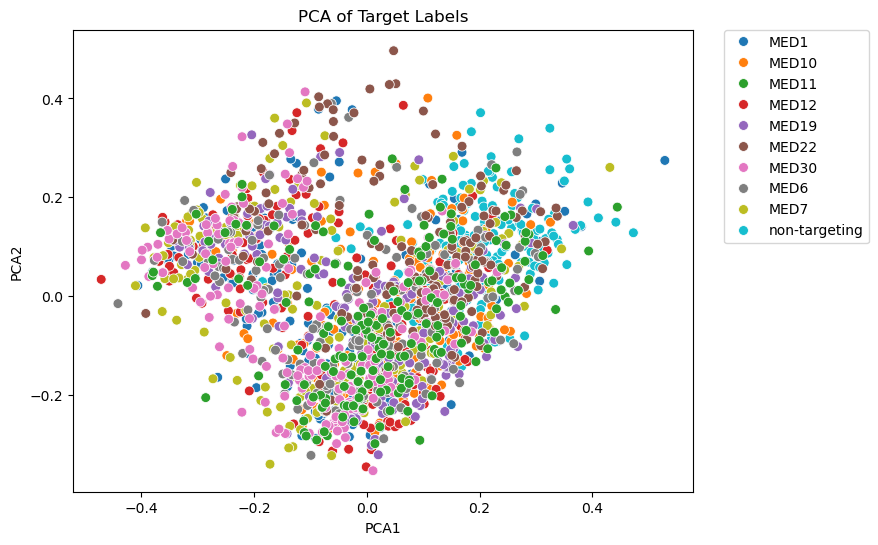

In [10]:
target_labels = ['non-targeting','MED1','MED6','MED7','MED10','MED11','MED12','MED19','MED22','MED30']
#target_labels = ['non-targeting','MED30']
plot_latent_pca_multi(gmm, rep, labels, target_labels=target_labels)

In [25]:
def plot_latent_umap_multi(gmm, rep, labels, target_labels=None, n_components=2):
    # 确保GMM模型在CPU上
    gmm = gmm.cpu()
    labels = np.array(labels)
    
    # 筛选目标标签的数据
    if target_labels is not None:
        if not isinstance(target_labels, (list, np.ndarray)):
            raise ValueError("target_labels should be a list or a NumPy array")
        
        if isinstance(target_labels, list):
            target_labels = np.array(target_labels)
        
        indices = np.where(np.isin(labels, target_labels))[0]
        embedding = rep.z[indices].detach().cpu().numpy().copy()  # 获取目标标签的数据
        labels = labels[indices].copy()
    else:
        embedding = rep.z.detach().cpu().numpy().copy()  # 获取所有数据
        labels = labels

    # 应用UMAP
    umap_reducer = umap.UMAP(n_components=n_components,
                        n_neighbors=10,  # 设定邻居数量
                        min_dist=0.3,    # 设定最小距离
                        spread=1.0,      # 设定分布宽度
                        metric='euclidean',  # 设定距离度量
                        random_state=42)   # 设定随机种子
    projected = umap_reducer.fit_transform(embedding)
    projected = umap_reducer.fit_transform(embedding)
    
    # 创建DataFrame用于绘图
    plot_data = pd.DataFrame(projected, columns=[f"UMAP{i+1}" for i in range(n_components)])
    plot_data["cell type"] = labels
    plot_data["cell type"] = plot_data["cell type"].astype("category")

    # 创建一个单一的散点图
    plt.figure(figsize=(8, 6))
    scatter_plot = sns.scatterplot(data=plot_data, x="UMAP1", y="UMAP2", hue="cell type", s=50)
    
    # 设置标题和图例
    plt.title("UMAP of Target Labels")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    
    # 保存和显示图像
    plt.savefig("analysis_umap_single.pdf", bbox_inches="tight")
    plt.savefig("analysis_umap_single.png", bbox_inches="tight", dpi=300)
    plt.show()


d:\anaconda\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
d:\anaconda\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


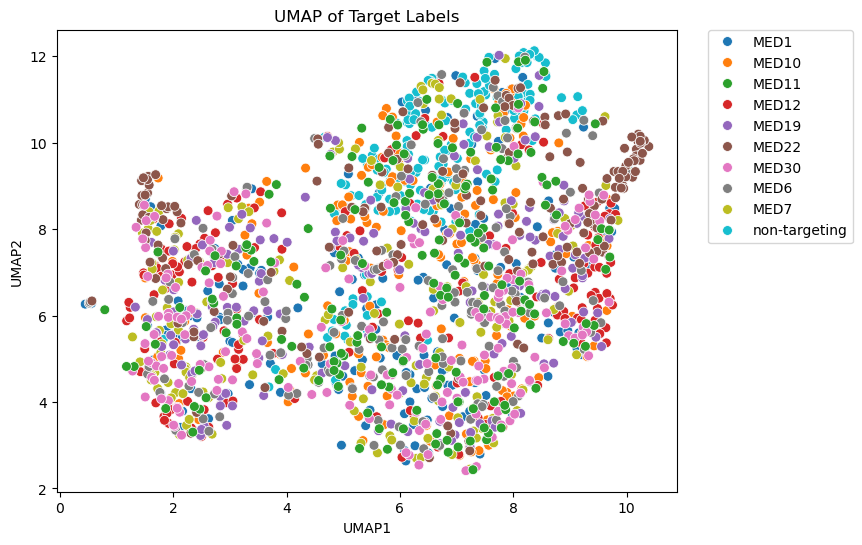

In [26]:
import umap.umap_ as umap
plot_latent_umap_multi(gmm, rep, labels, target_labels=target_labels)